# Paradigms of Machine Learning

## Project, Part 3:  Solving a “complex” ALE environment

In [1]:
!pip uninstall -y ale-py gymnasium
!pip install gymnasium==1.0.0
!pip install ale-py==0.10.1
!pip install stable-baselines3==2.4.0
!pip install supersuit==3.9.3
!pip install pettingzoo==1.24.3
!pip install AutoROM==0.6.1
!pip install multi-agent-ale-py==0.1.11
!pip install wandb==0.19.0

# Accept ROM license
!AutoROM --accept-license

Found existing installation: ale-py 0.11.2
Uninstalling ale-py-0.11.2:
  Successfully uninstalled ale-py-0.11.2
Found existing installation: gymnasium 0.29.0
Uninstalling gymnasium-0.29.0:
  Successfully uninstalled gymnasium-0.29.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 21.6 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, which is not installed.
stable-baselines3 2.1.0 requires gymnasium<0.30,>=0.28.1, but you have gymnasium 1.0.0 which is incompatible.
kaggle-environments 1.18.0 requires gymnasium==0.29.0, but you have gymnasium 1.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 

In [27]:
import numpy as np
import gymnasium as gym
import ale_py
import supersuit as ss
from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage, VecMonitor
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create directory for results
os.makedirs("./results", exist_ok=True)
os.makedirs("./logs", exist_ok=True)
os.makedirs("./models", exist_ok=True)

# 1. Configuration
ENV_NAME = "MsPacmanNoFrameskip-v4"
N_ENVS = 8
N_STACK = 4
TOTAL_TIMESTEPS = 1000000

# Create the vectorized environment with monitoring
print("Creating environment...")
env = make_atari_env(ENV_NAME, n_envs=N_ENVS, seed=42)
env = VecFrameStack(env, n_stack=N_STACK)
env = VecMonitor(env)  # Track episode rewards

print(f"Observation shape: {env.observation_space.shape}")

# Create separate evaluation environment
def make_eval_env():
    env = make_atari_env(ENV_NAME, n_envs=1, seed=123)
    env = VecFrameStack(env, n_stack=N_STACK)
    return env

eval_env = make_eval_env()

Creating environment...
Observation shape: (84, 84, 4)


## PPO (On-Policy)

In [28]:
import optuna

def objective_ppo(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True)
    n_steps = trial.suggest_categorical("n_steps", [128, 256, 512])
    batch_size = trial.suggest_categorical("batch_size", [128, 256])
    gamma = trial.suggest_float("gamma", 0.97, 0.999)
    clip_range = trial.suggest_float("clip_range", 0.05, 0.2)

    if (n_steps * 4) % batch_size != 0:
        raise optuna.exceptions.TrialPruned()

    env = make_atari_env(ENV_NAME, n_envs=4, seed=42)
    env = VecFrameStack(env, n_stack=N_STACK)
    env = VecMonitor(env)

    model = PPO(
        "CnnPolicy",
        env,
        learning_rate=learning_rate,
        n_steps=n_steps,
        batch_size=batch_size,
        n_epochs=4,
        gamma=gamma,
        clip_range=clip_range,
        ent_coef=0.01,
        verbose=0,
        policy_kwargs={"normalize_images": False}
    )

    model.learn(total_timesteps=100000)

    eval_env = make_atari_env(ENV_NAME, n_envs=1, seed=42)
    eval_env = VecFrameStack(eval_env, n_stack=N_STACK)
    mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=10)

    env.close(); eval_env.close()
    return mean_reward


N_TRIALS = 15

study_ppo = optuna.create_study(direction="maximize", study_name="ppo_ms_pacman")
study_ppo.optimize(objective_ppo, n_trials=N_TRIALS, show_progress_bar=True)
print("\nPPO Best hyperparameters:", study_ppo.best_params)
print("PPO Best value:", study_ppo.best_value)

[I 2025-12-14 19:05:34,896] A new study created in memory with name: ppo_ms_pacman


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-12-14 19:09:05,827] Trial 0 finished with value: 60.0 and parameters: {'learning_rate': 0.000143760344912829, 'n_steps': 256, 'batch_size': 128, 'gamma': 0.9845921942012119, 'clip_range': 0.16160551416945956}. Best is trial 0 with value: 60.0.
[I 2025-12-14 19:12:30,553] Trial 1 finished with value: 60.0 and parameters: {'learning_rate': 2.6019179052256328e-05, 'n_steps': 512, 'batch_size': 256, 'gamma': 0.9771278944268161, 'clip_range': 0.07320082301139605}. Best is trial 0 with value: 60.0.
[I 2025-12-14 19:16:01,581] Trial 2 finished with value: 384.0 and parameters: {'learning_rate': 1.0422263717372322e-05, 'n_steps': 512, 'batch_size': 128, 'gamma': 0.9938251767702659, 'clip_range': 0.1505751357967328}. Best is trial 2 with value: 384.0.
[I 2025-12-14 19:19:36,887] Trial 3 finished with value: 240.0 and parameters: {'learning_rate': 0.00037432278525618545, 'n_steps': 128, 'batch_size': 256, 'gamma': 0.9881786559303081, 'clip_range': 0.1872806187937862}. Best is trial 2 wit

In [29]:
print("Training PPO...")

ppo_best_params = study_ppo.best_params

ppo_model = PPO(
    "CnnPolicy",
    env,
    learning_rate=ppo_best_params["learning_rate"],
    n_steps=ppo_best_params["n_steps"],
    batch_size=ppo_best_params["batch_size"],
    n_epochs=4,
    gamma=ppo_best_params["gamma"],
    clip_range=ppo_best_params["clip_range"],
    ent_coef=0.01,
    verbose=1,
    tensorboard_log="./logs/optimized/",
    policy_kwargs={"normalize_images": False}
)

# Train with evaluation callback
ppo_eval_callback = EvalCallback(
    make_eval_env(),
    best_model_save_path="./models/best_ppo/",
    log_path="./logs/ppo_eval/",
    eval_freq=2000,
    deterministic=True,
    render=False
)

ppo_model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=[ppo_eval_callback],
    progress_bar=True,
    tb_log_name="ppo_training"
)

ppo_model.save("./models/ppo_ms_pacman_final")
print("PPO training complete and saved.")

Training PPO...
Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ./logs/optimized/ppo_training_3


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x78109e284e50> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x78109def4190>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 163      |
|    ep_rew_mean     | 9.14     |
| time/              |          |
|    fps             | 570      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 162         |
|    ep_rew_mean          | 8.93        |
| time/                   |             |
|    fps                  | 569         |
|    iterations           | 2           |
|    time_elapsed         | 14          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.047422845 |
|    clip_fraction        | 0.712       |
|    clip_range           | 0.181       |
|    entropy_loss         | -1.67       |
|    explained_variance   | -1.06       |
|    learning_rate        | 0.

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1,003,520/1,000,000  [ 0:38:06 < 0:00:00 , 398 it/s ]

PPO training complete and saved.


In [30]:
eval_env = make_eval_env()

mean_reward, std_reward = evaluate_policy(
    ppo_model,
    eval_env,
    n_eval_episodes=10,
    deterministic=True
)

print(f"PPO Evaluation → Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

PPO Evaluation → Mean reward: 1663.00 ± 364.88


## DQN (Off-Policy)

In [31]:
def objective_dqn(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True)
    buffer_size = trial.suggest_categorical("buffer_size", [100000, 200000])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    exploration_fraction = trial.suggest_float("exploration_fraction", 0.1, 0.3)
    exploration_final_eps = trial.suggest_float("exploration_final_eps", 0.01, 0.05)

    env = make_atari_env(ENV_NAME, n_envs=4, seed=42)
    env = VecFrameStack(env, n_stack=N_STACK)
    env = VecMonitor(env)

    model = DQN(
        "CnnPolicy",
        env,
        learning_rate=learning_rate,
        buffer_size=buffer_size,
        learning_starts=10000,
        batch_size=batch_size,
        gamma=0.99,
        train_freq=4,
        target_update_interval=1000,
        exploration_fraction=exploration_fraction,
        exploration_final_eps=exploration_final_eps,
        verbose=0,
        policy_kwargs={"normalize_images": False}
    )

    model.learn(total_timesteps=100000)

    eval_env = make_atari_env(ENV_NAME, n_envs=1, seed=42)
    eval_env = VecFrameStack(eval_env, n_stack=N_STACK)
    mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=10)

    env.close(); eval_env.close()
    return mean_reward

study_dqn = optuna.create_study(direction="maximize", study_name="dqn_ms_pacman")
study_dqn.optimize(objective_dqn, n_trials=N_TRIALS, show_progress_bar=True)
print("\nDQN Best hyperparameters:", study_dqn.best_params)
print("DQN Best value:", study_dqn.best_value)

[I 2025-12-14 20:37:33,379] A new study created in memory with name: dqn_ms_pacman


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-12-14 20:40:49,040] Trial 0 finished with value: 419.0 and parameters: {'learning_rate': 8.895566852389869e-05, 'buffer_size': 200000, 'batch_size': 64, 'exploration_fraction': 0.2605032871514573, 'exploration_final_eps': 0.02836338465031056}. Best is trial 0 with value: 419.0.
[I 2025-12-14 20:44:05,371] Trial 1 finished with value: 305.0 and parameters: {'learning_rate': 0.00030350686418001595, 'buffer_size': 200000, 'batch_size': 64, 'exploration_fraction': 0.22708696888544094, 'exploration_final_eps': 0.024096836801111507}. Best is trial 0 with value: 419.0.
[I 2025-12-14 20:47:42,085] Trial 2 finished with value: 373.0 and parameters: {'learning_rate': 1.331038487783375e-05, 'buffer_size': 200000, 'batch_size': 128, 'exploration_fraction': 0.12879685909529395, 'exploration_final_eps': 0.049339433087745264}. Best is trial 0 with value: 419.0.
[I 2025-12-14 20:50:46,553] Trial 3 finished with value: 123.0 and parameters: {'learning_rate': 0.0003848803818384977, 'buffer_size'

In [32]:
print("Training DQN...")

dqn_best_params = study_dqn.best_params

# Need separate env for DQN (can't share with PPO)
dqn_train_env = make_atari_env(ENV_NAME, n_envs=N_ENVS, seed=42)
dqn_train_env = VecFrameStack(dqn_train_env, n_stack=N_STACK)
dqn_train_env = VecMonitor(dqn_train_env)

dqn_model = DQN(
    "CnnPolicy",
    dqn_train_env,
    learning_rate=dqn_best_params["learning_rate"],
    buffer_size=dqn_best_params["buffer_size"],
    learning_starts=10000,
    batch_size=dqn_best_params["batch_size"],
    gamma=0.99,
    train_freq=4,
    target_update_interval=1000,
    exploration_fraction=dqn_best_params["exploration_fraction"],
    exploration_final_eps=dqn_best_params["exploration_final_eps"],
    verbose=1,
    tensorboard_log="./logs/optimized/",
    policy_kwargs={"normalize_images": False}
)

dqn_eval_callback = EvalCallback(
    make_eval_env(),
    best_model_save_path="./models/best_dqn/",
    log_path="./logs/dqn_eval/",
    eval_freq=2000,
    deterministic=True
)

dqn_model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=[dqn_eval_callback],
    progress_bar=True,
    tb_log_name="dqn_training"
)

dqn_model.save("./models/dqn_ms_pacman_final")
print("DQN training complete and saved.")

Training DQN...
Using cuda device
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.65GB > 1.51GB
  warnings.warn(


Logging to ./logs/optimized/dqn_training_1


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x78108ea152d0> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x78108ea39f90>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 176      |
|    ep_rew_mean      | 10       |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 490      |
|    time_elapsed     | 3        |
|    total_timesteps  | 1512     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 188      |
|    ep_rew_mean      | 12.1     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 517      |
|    time_elapsed     | 3        |
|    total_timesteps  | 1712     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 164      |
|    ep_rew_mean      | 9.83     |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes       

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1,000,000/1,000,000  [ 0:29:52 < 0:00:00 , 540 it/s ]

DQN training complete and saved.


In [33]:
eval_env = make_eval_env()

mean_reward, std_reward = evaluate_policy(
    dqn_model,
    eval_env,
    n_eval_episodes=10,
    deterministic=True
)

print(f"DQN Evaluation → Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

DQN Evaluation → Mean reward: 677.00 ± 362.24


## A2C

In [34]:
def objective_a2c(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True)
    n_steps = trial.suggest_categorical("n_steps", [5, 10, 20])
    ent_coef = trial.suggest_float("ent_coef", 0.0, 0.05)

    env = make_atari_env(ENV_NAME, n_envs=4, seed=42)
    env = VecFrameStack(env, n_stack=N_STACK)
    env = VecMonitor(env)

    model = A2C(
        "CnnPolicy",
        env,
        learning_rate=learning_rate,
        n_steps=n_steps,
        gamma=0.99,
        ent_coef=ent_coef,
        vf_coef=0.5,
        verbose=0,
        policy_kwargs={"normalize_images": False}
    )

    model.learn(total_timesteps=100000)

    eval_env = make_atari_env(ENV_NAME, n_envs=1, seed=42)
    eval_env = VecFrameStack(eval_env, n_stack=N_STACK)
    mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=10)

    env.close(); eval_env.close()
    return mean_reward

study_a2c = optuna.create_study(direction="maximize", study_name="a2c_ms_pacman")
study_a2c.optimize(objective_a2c, n_trials=N_TRIALS, show_progress_bar=True)
print("\nA2C Best hyperparameters:", study_a2c.best_params)
print("A2C Best value:", study_a2c.best_value)

[I 2025-12-14 21:57:48,534] A new study created in memory with name: a2c_ms_pacman


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-12-14 22:00:58,405] Trial 0 finished with value: 70.0 and parameters: {'learning_rate': 4.0224807931440906e-05, 'n_steps': 10, 'ent_coef': 0.010299910062654079}. Best is trial 0 with value: 70.0.
[I 2025-12-14 22:04:11,042] Trial 1 finished with value: 491.0 and parameters: {'learning_rate': 0.0002387576051438125, 'n_steps': 20, 'ent_coef': 0.04964542537992159}. Best is trial 1 with value: 491.0.
[I 2025-12-14 22:07:12,590] Trial 2 finished with value: 210.0 and parameters: {'learning_rate': 1.1327930163029249e-05, 'n_steps': 20, 'ent_coef': 0.022209937468495245}. Best is trial 1 with value: 491.0.
[I 2025-12-14 22:10:21,656] Trial 3 finished with value: 60.0 and parameters: {'learning_rate': 4.798710000201115e-05, 'n_steps': 10, 'ent_coef': 0.02340498410129891}. Best is trial 1 with value: 491.0.
[I 2025-12-14 22:13:45,853] Trial 4 finished with value: 70.0 and parameters: {'learning_rate': 5.8788636286929145e-05, 'n_steps': 5, 'ent_coef': 0.011835980415190663}. Best is trial 

In [36]:
print("Training A2C...")

a2c_best_params = study_a2c.best_params

a2c_train_env = make_atari_env(ENV_NAME, n_envs=N_ENVS, seed=42)
a2c_train_env = VecFrameStack(a2c_train_env, n_stack=N_STACK)
a2c_train_env = VecMonitor(a2c_train_env)

a2c_model = A2C(
    "CnnPolicy",
    a2c_train_env,
    learning_rate=a2c_best_params["learning_rate"],
    n_steps=a2c_best_params["n_steps"],
    gamma=0.99,
    ent_coef=a2c_best_params["ent_coef"],
    vf_coef=0.5,
    verbose=1,
    tensorboard_log="./logs/optimized/",
    policy_kwargs={"normalize_images": False}
)

a2c_eval_callback = EvalCallback(
    make_eval_env(),
    best_model_save_path="./models/best_a2c/",
    log_path="./logs/a2c_eval/",
    eval_freq=2000,
    deterministic=True
)

a2c_model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=[a2c_eval_callback],
    progress_bar=True,
    tb_log_name="a2c_training"
)

a2c_model.save("./models/a2c_ms_pacman_final")
print("A2C training complete and saved.")

Training A2C...
Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ./logs/optimized/a2c_training_1


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x78109e0d77d0> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x78108ea392d0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=16000, episode_reward=60.00 +/- 0.00
Episode length: 1857.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 1.86e+03 |
|    mean_reward        | 60       |
| time/                 |          |
|    total_timesteps    | 16000    |
| train/                |          |
|    entropy_loss       | -1.83    |
|    explained_variance | 0.109    |
|    learning_rate      | 0.000239 |
|    n_updates          | 99       |
|    policy_loss        | -0.36    |
|    value_loss         | 2.62     |
------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 204      |
|    ep_rew_mean     | 14.3     |
| time/              |          |
|    fps             | 513      |
|    iterations      | 100      |
|    time_elapsed    | 31       |
|    total_timesteps | 16000    |
---------------------------------
Eval num_timesteps=32000, episo

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1,000,000/1,000,000  [ 0:31:11 < 0:00:00 , 572 it/s ]

A2C training complete and saved.


In [43]:
eval_env = make_eval_env()

mean_reward, std_reward = evaluate_policy(
    a2c_model,
    eval_env,
    n_eval_episodes=10,
    deterministic=True
)

print(f"A2C Evaluation → Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

A2C Evaluation → Mean reward: 210.00 ± 0.00


## Evaluation & Comparison

In [42]:
import pandas as pd
from stable_baselines3.common.evaluation import evaluate_policy

# List of models to evaluate
model_names = ["PPO", "DQN", "A2C"]
model_paths = [
    "./models/ppo_ms_pacman_final.zip",
    "./models/dqn_ms_pacman_final.zip",
    "./models/a2c_ms_pacman_final.zip"
]
model_classes = [PPO, DQN, A2C]

results = []

print("Starting final evaluations...")

for name, path, model_cls in zip(model_names, model_paths, model_classes):
    # Load model
    model = model_cls.load(path)
    
    # Evaluate over 20 episodes
    mean_reward, std_reward = evaluate_policy(
        model, 
        make_eval_env(), 
        n_eval_episodes=20, 
        deterministic=True
    )
    
    results.append({
        "Model": name,
        "Mean Reward": round(mean_reward, 2),
        "Std Dev": round(std_reward, 2)
    })
    print(f"Finished evaluating {name}")

# Create and display table
df_results = pd.DataFrame(results)
df_results.to_csv("./results/pacman_comparison_table.csv", index=False)
print("\n--- Final Performance Comparison ---")
print(df_results)

Starting final evaluations...
Finished evaluating PPO
Finished evaluating DQN
Finished evaluating A2C

--- Final Performance Comparison ---
  Model  Mean Reward  Std Dev
0   PPO       1675.5   354.31
1   DQN        680.5   359.49
2   A2C        210.0     0.00


## Plotting Training

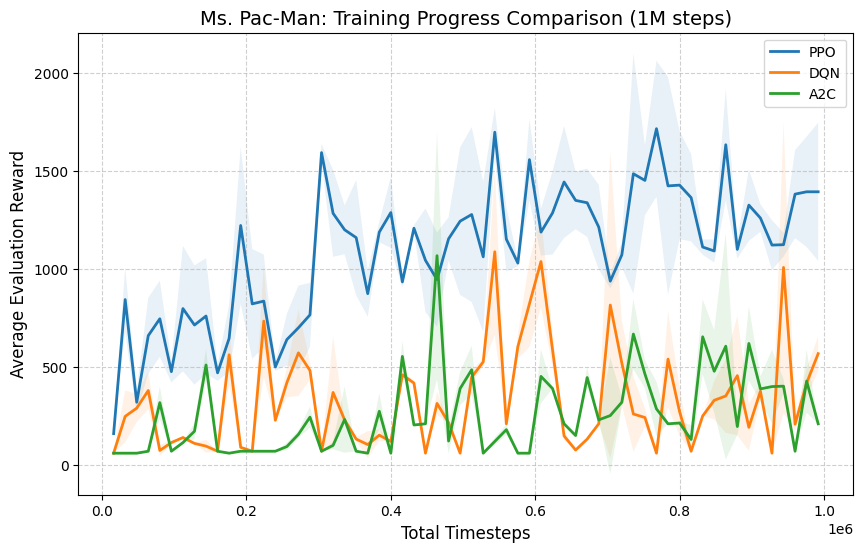

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pacman_results(eval_log_paths, labels):
    plt.figure(figsize=(10, 6))
    
    for log_path, label in zip(eval_log_paths, labels):
        # Load the .npz file created by EvalCallback
        data = np.load(f"{log_path}/evaluations.npz")
        timesteps = data['timesteps']
        # results shape is (n_evaluations, n_eval_episodes), we want the mean across episodes
        mean_rewards = np.mean(data['results'], axis=1)
        
        plt.plot(timesteps, mean_rewards, label=label, linewidth=2)
        plt.fill_between(
            timesteps, 
            mean_rewards - np.std(data['results'], axis=1), 
            mean_rewards + np.std(data['results'], axis=1), 
            alpha=0.1
        )

    plt.title(f"Ms. Pac-Man: Training Progress Comparison (1M steps)", fontsize=14)
    plt.xlabel("Total Timesteps", fontsize=12)
    plt.ylabel("Average Evaluation Reward", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig("./results/training_comparison_plot.png")
    plt.show()

# Run the plotting function
eval_paths = ["./logs/ppo_eval/", "./logs/dqn_eval/", "./logs/a2c_eval/"]
plot_pacman_results(eval_paths, ["PPO", "DQN", "A2C"])

In [40]:
from stable_baselines3.common.vec_env import VecVideoRecorder

os.makedirs("./videos", exist_ok=True)

def record_gameplay(model, model_name, video_length=2000):
    """
    Record a single gameplay video for a trained model.
    """

    # Create evaluation environment
    video_env = make_atari_env(ENV_NAME, n_envs=1, seed=42)
    video_env = VecFrameStack(video_env, n_stack=N_STACK)

    # Wrap with video recorder
    video_env = VecVideoRecorder(
        video_env,
        video_folder="./videos/",
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=model_name
    )

    obs = video_env.reset()
    done = False
    step = 0

    print(f"Recording video for {model_name}...")

    while not done and step < video_length:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _ = video_env.step(action)
        step += 1

    video_env.close()
    print(f"Saved video: ./videos/{model_name}-step-0.mp4")

# Load trained models
ppo_model = PPO.load("./models/ppo_ms_pacman_final")
dqn_model = DQN.load("./models/dqn_ms_pacman_final")
a2c_model = A2C.load("./models/a2c_ms_pacman_final")

# Record gameplay
record_gameplay(ppo_model, "PPO_MsPacman")
record_gameplay(dqn_model, "DQN_MsPacman")
record_gameplay(a2c_model, "A2C_MsPacman")

Recording video for PPO_MsPacman...


/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /kaggle/working/videos/PPO_MsPacman-step-0-to-step-2000.mp4.
Moviepy - Writing video /kaggle/working/videos/PPO_MsPacman-step-0-to-step-2000.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/videos/PPO_MsPacman-step-0-to-step-2000.mp4
Saved video: ./videos/PPO_MsPacman-step-0.mp4
Recording video for DQN_MsPacman...
Moviepy - Building video /kaggle/working/videos/DQN_MsPacman-step-0-to-step-2000.mp4.
Moviepy - Writing video /kaggle/working/videos/DQN_MsPacman-step-0-to-step-2000.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/videos/DQN_MsPacman-step-0-to-step-2000.mp4
Saved video: ./videos/DQN_MsPacman-step-0.mp4


Recording video for A2C_MsPacman...
Moviepy - Building video /kaggle/working/videos/A2C_MsPacman-step-0-to-step-2000.mp4.
Moviepy - Writing video /kaggle/working/videos/A2C_MsPacman-step-0-to-step-2000.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/videos/A2C_MsPacman-step-0-to-step-2000.mp4
Saved video: ./videos/A2C_MsPacman-step-0.mp4
